In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import models, datasets, transforms
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader
import torchvision
import torchvision
from torchvision import transforms


In [12]:
data_dir = r'C:\Users\merug\Downloads\fall_detection\fall_detection_data'
batch_size = 32

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(), # convert 1 to 3 channels
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Train dataset and dataloader
train_dataset = torchvision.datasets.ImageFolder(f'{data_dir}/train', transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_sizes = len(train_dataset)
class_names = train_dataset.classes

# Validation dataset and dataloader
val_dataset = torchvision.datasets.ImageFolder(f'{data_dir}/val', transform)

val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size)

val_sizes = len(val_dataset)

In [13]:
# Test dataset and dataloader
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform)

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

test_sizes = len(test_dataset)

In [14]:
# Model definition using VGG16 (with fine-tuning)
class VGG16Net(nn.Module):
    def __init__(self, out_features=2):
        super(VGG16Net, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        # Fine-tuning by freezing layers except the classifier
        for param in vgg16.features.parameters():
            param.requires_grad = False

        # Modify the classifier for the fall detection task
        in_features = vgg16.classifier[6].in_features  # Extract in_features of the original classifier
        vgg16.classifier[6] = nn.Linear(in_features, out_features)  # Replace with new classifier
        self.vgg16 = vgg16

    def forward(self, x):
        return self.vgg16(x)


In [15]:
# Initialize the VGG16 model
model = VGG16Net(out_features=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

VGG16Net(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [16]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.vgg16.classifier.parameters(), lr=0.001, momentum=0.9)


In [17]:
# Training function
def train(model, optimizer, loss_fn, train_loader, val_loader, start_epoch=0, epochs=20, device="cpu"):
    model.to(device)
    train_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in range(start_epoch, start_epoch + epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()

        # Training phase
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        train_losses.append(training_loss)

        # Validation phase
        model.eval()
        num_correct = 0
        num_examples = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)
                output = model(inputs)
                loss = loss_fn(output, targets)
                valid_loss += loss.data.item() * inputs.size(0)
                correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)
        val_losses.append(valid_loss)

        accuracy = num_correct / num_examples
        accuracies.append(accuracy)

        print(f'Epoch: {epoch}, Training Loss: {training_loss:.2f}, Validation Loss: {valid_loss:.2f}, Accuracy: {accuracy:.2f}')

    return train_losses, val_losses, accuracies

In [18]:
# Train the model
epochs = 20
train_losses, val_losses, accuracies = train(model, optimizer, criterion, train_dataloader, val_dataloader, epochs=epochs, device=device)

Epoch: 0, Training Loss: 0.32, Validation Loss: 0.21, Accuracy: 0.91
Epoch: 1, Training Loss: 0.19, Validation Loss: 0.19, Accuracy: 0.91
Epoch: 2, Training Loss: 0.14, Validation Loss: 0.17, Accuracy: 0.92
Epoch: 3, Training Loss: 0.11, Validation Loss: 0.17, Accuracy: 0.93
Epoch: 4, Training Loss: 0.10, Validation Loss: 0.12, Accuracy: 0.95
Epoch: 5, Training Loss: 0.08, Validation Loss: 0.12, Accuracy: 0.95
Epoch: 6, Training Loss: 0.06, Validation Loss: 0.12, Accuracy: 0.96
Epoch: 7, Training Loss: 0.06, Validation Loss: 0.11, Accuracy: 0.96
Epoch: 8, Training Loss: 0.05, Validation Loss: 0.11, Accuracy: 0.96
Epoch: 9, Training Loss: 0.04, Validation Loss: 0.11, Accuracy: 0.96
Epoch: 10, Training Loss: 0.04, Validation Loss: 0.10, Accuracy: 0.96
Epoch: 11, Training Loss: 0.04, Validation Loss: 0.10, Accuracy: 0.96
Epoch: 12, Training Loss: 0.03, Validation Loss: 0.12, Accuracy: 0.97
Epoch: 13, Training Loss: 0.03, Validation Loss: 0.12, Accuracy: 0.97
Epoch: 14, Training Loss: 0.02

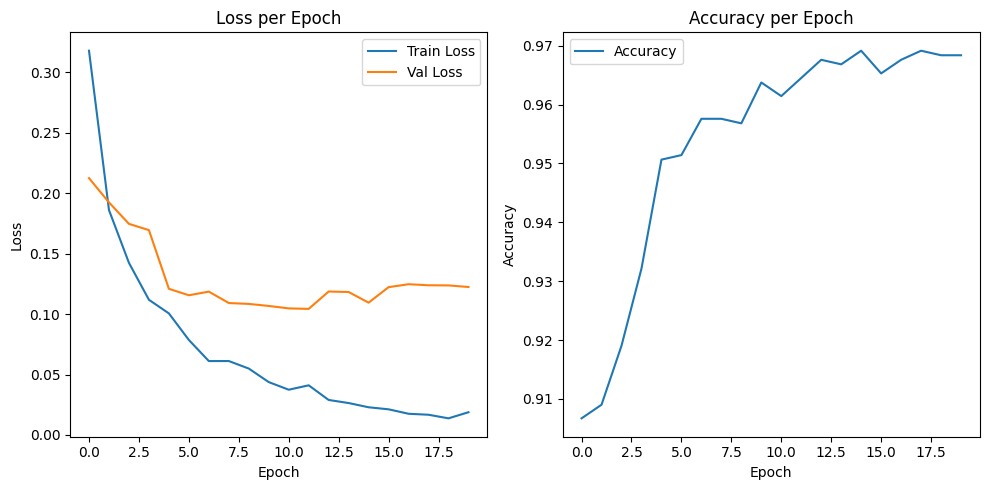

In [19]:
# Plot the training and validation loss and accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
# Save the model from the last fold
os.makedirs(f'train_model', exist_ok=True)
torch.save(model.state_dict(), 'train_model/vgg16_finetuned.pt')

evaluation

In [22]:
# Evaluate on test data
model.eval()
outputs_np = np.empty((0), dtype=int)
targets_np = np.empty((0), dtype=int)

num_correct = 0
num_examples = 0
for batch in test_dataloader:
    inputs, targets = batch
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
    targets = targets.to(device)
    correct = torch.eq(outputs, targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
    
    outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
    targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

print(f'Accuracy on test data: {num_correct / num_examples:.2f}')


Accuracy on test data: 0.97


In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(targets_np, outputs_np)
print(cf_matrix)

[[ 194   17]
 [  27 1125]]


In [25]:
# Implement K-Fold Cross-Validation
def cross_validation(model, dataset, k_folds=5, epochs=20):
    kfold = KFold(n_splits=k_folds, shuffle=True)
    fold_results = []
    
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'Fold {fold + 1}')
        
        # Create samplers for train and validation sets
        train_sampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_ids)

        # Create loaders
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)

        # Initialize a fresh model and optimizer for each fold
        model = VGG16Net().to(device)
        optimizer = optim.SGD(model.vgg16.classifier.parameters(), lr=0.001, momentum=0.9)

        # Train the model
        train_losses, val_losses, accuracies = train(
            model, optimizer, criterion, train_loader, val_loader, epochs=epochs, device=device
        )
        
        # Store results of the fold
        fold_results.append({'train_loss': train_losses, 'val_loss': val_losses, 'accuracy': accuracies})
    
    return fold_results

In [26]:
# Load the entire dataset for cross-validation
dataset = datasets.ImageFolder(f'{data_dir}/train', transform=transform)

In [27]:
# Define the loss function.
criterion = nn.CrossEntropyLoss()

Fold 1


c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch: 0, Training Loss: 0.27, Validation Loss: 0.05, Accuracy: 0.89
Epoch: 1, Training Loss: 0.15, Validation Loss: 0.04, Accuracy: 0.90
Epoch: 2, Training Loss: 0.12, Validation Loss: 0.04, Accuracy: 0.89
Epoch: 3, Training Loss: 0.10, Validation Loss: 0.03, Accuracy: 0.92
Epoch: 4, Training Loss: 0.09, Validation Loss: 0.03, Accuracy: 0.93
Epoch: 5, Training Loss: 0.07, Validation Loss: 0.03, Accuracy: 0.93
Epoch: 6, Training Loss: 0.06, Validation Loss: 0.03, Accuracy: 0.94
Epoch: 7, Training Loss: 0.05, Validation Loss: 0.03, Accuracy: 0.93
Epoch: 8, Training Loss: 0.04, Validation Loss: 0.03, Accuracy: 0.93
Epoch: 9, Training Loss: 0.03, Validation Loss: 0.03, Accuracy: 0.95
Fold 2
Epoch: 0, Training Loss: 0.26, Validation Loss: 0.03, Accuracy: 0.93
Epoch: 1, Training Loss: 0.17, Validation Loss: 0.03, Accuracy: 0.95
Epoch: 2, Training Loss: 0.13, Validation Loss: 0.02, Accuracy: 0.95
Epoch: 3, Training Loss: 0.10, Validation Loss: 0.02, Accuracy: 0.95
Epoch: 4, Training Loss: 0.

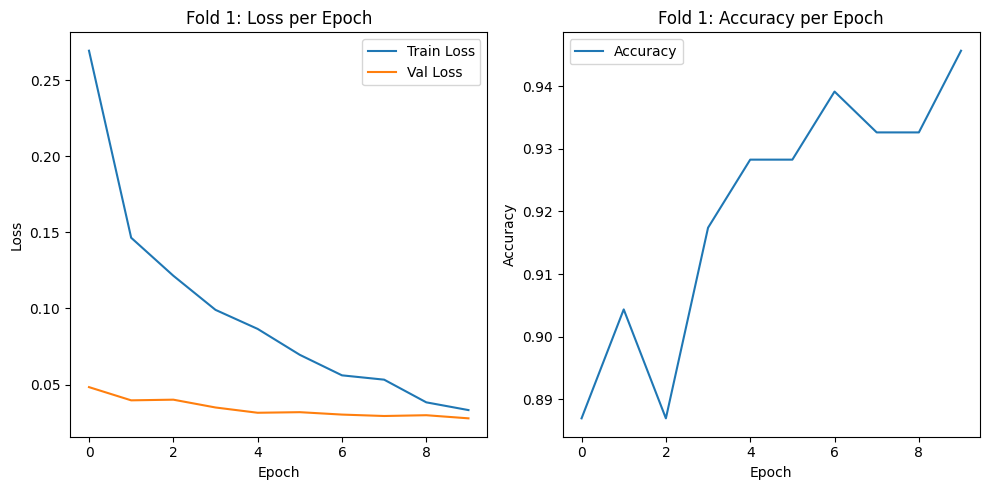

In [28]:
# Perform cross-validation
k_folds = 5
cv_results = cross_validation(VGG16Net, dataset, k_folds=k_folds, epochs=10)

# Plotting example for one of the folds
fold_number = 0  # Change this to visualize different folds
train_losses = cv_results[fold_number]['train_loss']
val_losses = cv_results[fold_number]['val_loss']
accuracies = cv_results[fold_number]['accuracy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title(f'Fold {fold_number + 1}: Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Accuracy')
plt.title(f'Fold {fold_number + 1}: Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [29]:
# Save the model from the last fold
os.makedirs(f'train_model', exist_ok=True)
torch.save(model.state_dict(), 'train_model/vgg16_finetuned.pt')

In [30]:
# Test dataset and dataloader
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [31]:
# Evaluate on test data
model.eval()
outputs_np = np.empty((0), dtype=int)
targets_np = np.empty((0), dtype=int)

num_correct = 0
num_examples = 0
for batch in test_loader:
    inputs, targets = batch
    inputs = inputs.to(device)
    outputs = model(inputs)
    outputs = torch.max(F.softmax(outputs, dim=1), dim=1)[1]
    targets = targets.to(device)
    correct = torch.eq(outputs, targets).view(-1)
    num_correct += torch.sum(correct).item()
    num_examples += correct.shape[0]
    
    outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
    targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

print(f'Accuracy on test data: {num_correct / num_examples:.2f}')

Accuracy on test data: 0.97


In [32]:
from sklearn.metrics import confusion_matrix

In [33]:
# Confusion matrix
cf_matrix = confusion_matrix(targets_np, outputs_np)
print(cf_matrix)

[[ 194   17]
 [  27 1125]]


general vgg16

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.cuda.amp import GradScaler, autocast
import numpy as np
import matplotlib.pyplot as plt
import os

In [35]:
# Model definition using VGG16 (general model, all layers trainable)
class VGG16NetGeneral(nn.Module):
    def __init__(self, out_features=2):
        super(VGG16NetGeneral, self).__init__()
        vgg16 = models.vgg16(pretrained=True)
        
        # Modify the classifier for the fall detection task
        in_features = vgg16.classifier[6].in_features
        vgg16.classifier[6] = nn.Linear(in_features, out_features)
        self.vgg16 = vgg16

    def forward(self, x):
        return self.vgg16(x)


In [36]:
# Initialize the VGG16 model
model = VGG16NetGeneral(out_features=2)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG16NetGeneral(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [37]:

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Use Adam optimizer for faster convergence
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Implement mixed precision training
scaler = GradScaler()



C:\Users\merug\AppData\Local\Temp\ipykernel_22788\4179050943.py:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [38]:
# Data directory and transformations
data_dir = r'C:\Users\merug\Downloads\fall_detection\fall_detection_data'
batch_size = 16  # Reduced batch size

# Data transformations (reduce image size)
transform = transforms.Compose([
    transforms.Resize(112),
    transforms.CenterCrop(112),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset and DataLoaders
train_dataset = datasets.ImageFolder(f'{data_dir}/train', transform=transform)
val_dataset = datasets.ImageFolder(f'{data_dir}/val', transform=transform)
test_dataset = datasets.ImageFolder(f'{data_dir}/test', transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


In [39]:
# Early Stopping Implementation
class EarlyStopping:
    def __init__(self, patience=3):
        self.patience = patience
        self.counter = 0
        self.best_loss = None

    def check_early_stopping(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

early_stopping = EarlyStopping(patience=3)

In [40]:
# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2)

# Training function with mixed precision and early stopping
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    train_losses = []
    val_losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        training_loss = 0.0

        for batch in train_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            with autocast():
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            training_loss += loss.item() * inputs.size(0)

        training_loss /= len(train_loader.dataset)
        train_losses.append(training_loss)

        # Validation phase
        model.eval()
        valid_loss = 0.0
        num_correct = 0
        num_examples = 0

        with torch.no_grad():
            for batch in val_loader:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)

                with autocast():
                    outputs = model(inputs)
                    loss = loss_fn(outputs, targets)

                valid_loss += loss.item() * inputs.size(0)
                correct = torch.eq(torch.max(outputs, dim=1)[1], targets).view(-1)
                num_correct += torch.sum(correct).item()
                num_examples += correct.shape[0]

        valid_loss /= len(val_loader.dataset)
        val_losses.append(valid_loss)
        accuracy = num_correct / num_examples
        accuracies.append(accuracy)

        print(f'Epoch {epoch+1}, Train Loss: {training_loss:.4f}, Val Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}')

        # Adjust learning rate
        scheduler.step(valid_loss)

        # Early stopping
        if early_stopping.check_early_stopping(valid_loss):
            print("Early stopping triggered")
            break

    return train_losses, val_losses, accuracies

In [41]:
# Train the model
train_losses, val_losses, accuracies = train(model, optimizer, criterion, train_loader, val_loader, epochs=20, device=device)

C:\Users\merug\AppData\Local\Temp\ipykernel_22788\1314050876.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
C:\Users\merug\AppData\Local\Temp\ipykernel_22788\1314050876.py:43: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Train Loss: 0.2784, Val Loss: 0.1978, Accuracy: 0.9121
Epoch 2, Train Loss: 0.1990, Val Loss: 0.1947, Accuracy: 0.9160
Epoch 3, Train Loss: 0.1290, Val Loss: 0.2029, Accuracy: 0.9445
Epoch 4, Train Loss: 0.0757, Val Loss: 0.1394, Accuracy: 0.9715
Epoch 5, Train Loss: 0.0501, Val Loss: 0.1977, Accuracy: 0.9375
Epoch 6, Train Loss: 0.0414, Val Loss: 0.1632, Accuracy: 0.9699
Epoch 7, Train Loss: 0.0432, Val Loss: 0.3002, Accuracy: 0.9391
Early stopping triggered


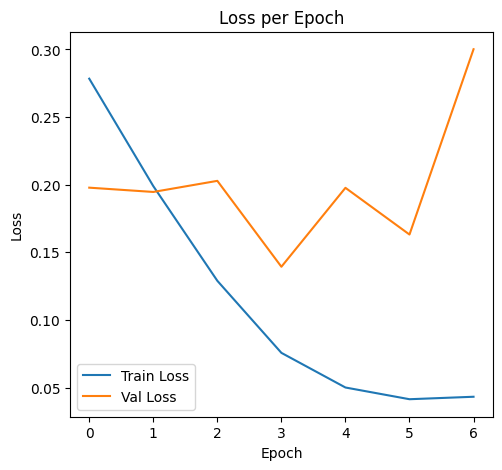

In [42]:

# Plotting Training & Validation Loss and Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


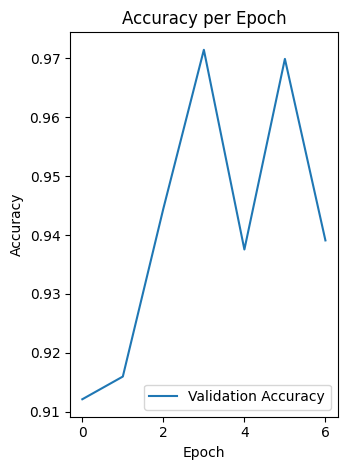

In [43]:
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [44]:
# Evaluate on test data
def test(model, test_loader, device):
    model.eval()
    num_correct = 0
    num_examples = 0
    outputs_np, targets_np = np.empty((0), dtype=int), np.empty((0), dtype=int)

    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            with autocast():
                outputs = model(inputs)
            outputs = torch.max(outputs, dim=1)[1]

            correct = torch.eq(outputs, targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]

            outputs_np = np.concatenate([outputs_np, outputs.cpu().numpy()], axis=None)
            targets_np = np.concatenate([targets_np, targets.cpu().numpy()], axis=None)

    accuracy = num_correct / num_examples
    print(f'Accuracy on test data: {accuracy:.4f}')
    return outputs_np, targets_np

In [45]:

# Evaluate the model on the test set
outputs_np, targets_np = test(model, test_loader, device)

C:\Users\merug\AppData\Local\Temp\ipykernel_22788\2612479398.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Accuracy on test data: 0.9193


In [46]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(targets_np, outputs_np)
print("Confusion Matrix:")
print(cf_matrix)

Confusion Matrix:
[[ 210    1]
 [ 109 1043]]


In [47]:
# Save the model from the last fold
os.makedirs(f'train_model', exist_ok=True)
torch.save(model.state_dict(), 'train_model/vgg16.pt')

In [48]:
from sklearn.metrics import precision_score
precision = precision_score(targets_np, outputs_np)
print(f'Precision: {precision:.4f}')


Precision: 0.9990


In [49]:
from sklearn.metrics import recall_score
recall = recall_score(targets_np, outputs_np)
print(f'Recall: {recall:.4f}')


Recall: 0.9054


In [50]:
from sklearn.metrics import f1_score
f1 = f1_score(targets_np, outputs_np)
print(f'F1-Score: {f1:.4f}')


F1-Score: 0.9499


In [51]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(targets_np, outputs_np)
print(f'AUC: {auc:.4f}')


AUC: 0.9503


In [52]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(targets_np, outputs_np)
print(f'AUC: {auc:.4f}')


AUC: 0.9503


In [53]:
# Initialize the model
model = VGG16NetGeneral(out_features=2)  # Make sure to initialize the model properly

# Load the saved model weights
model_path = 'train_model/vgg16.pt'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()  # This disables layers like dropout and batchnorm from updating during inference


c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\merug\AppData\Local\Temp\ipykernel_22788\2946554566.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/

VGG16NetGeneral(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
    

In [54]:
from sklearn.metrics import precision_score
precision = precision_score(targets_np, outputs_np)
print(f'Precision: {precision:.4f}')


Precision: 0.9990


In [55]:
from sklearn.metrics import recall_score
recall = recall_score(targets_np, outputs_np)
print(f'Recall: {recall:.4f}')


Recall: 0.9054


In [56]:
from sklearn.metrics import f1_score
f1 = f1_score(targets_np, outputs_np)
print(f'F1-Score: {f1:.4f}')


F1-Score: 0.9499


In [57]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(targets_np, outputs_np)
print(f'AUC: {auc:.4f}')


AUC: 0.9503


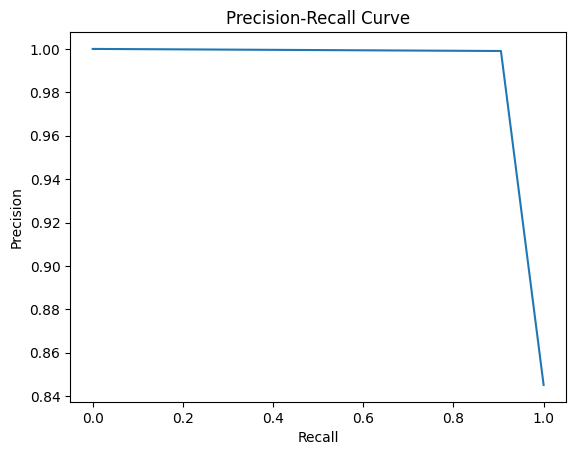

In [58]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(targets_np, outputs_np)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()


laod fine tuned model

In [59]:
# Initialize the model
model = VGG16Net(out_features=2)  # Make sure to initialize the model properly

# Load the saved model weights
model_path = 'train_model/vgg16_finetuned.pt'
model.load_state_dict(torch.load(model_path))

# Set the model to evaluation mode
model.eval()  # This disables layers like dropout and batchnorm from updating during inference


c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\merug\anaconda3\envs\cuda_test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\merug\AppData\Local\Temp\ipykernel_22788\3201923539.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/

VGG16Net(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16):

In [60]:
from sklearn.metrics import precision_score
precision = precision_score(targets_np, outputs_np)
print(f'Precision: {precision:.4f}')


Precision: 0.9990


In [61]:
from sklearn.metrics import recall_score
recall = recall_score(targets_np, outputs_np)
print(f'Recall: {recall:.4f}')


Recall: 0.9054


In [62]:
from sklearn.metrics import f1_score
f1 = f1_score(targets_np, outputs_np)
print(f'F1-Score: {f1:.4f}')


F1-Score: 0.9499


In [63]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(targets_np, outputs_np)
print(f'AUC: {auc:.4f}')


AUC: 0.9503


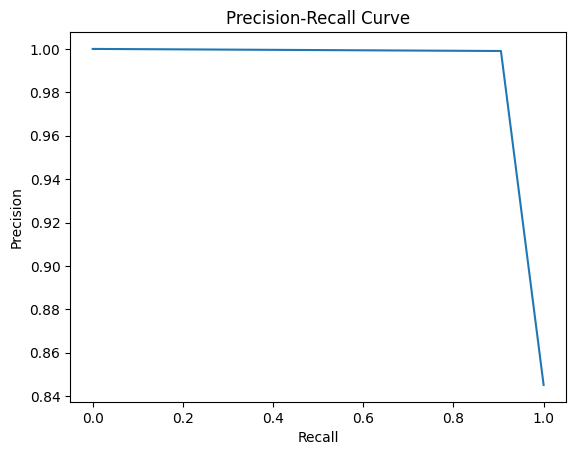

In [64]:
from sklearn.metrics import precision_recall_curve
precision, recall, _ = precision_recall_curve(targets_np, outputs_np)
plt.plot(recall, precision)
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()
